In [195]:
from itertools import repeat
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
def no_labels():
    plt.tick_params(
        which='both',
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False)

In [196]:
cap = cv.VideoCapture("data/0001-0030.avi")

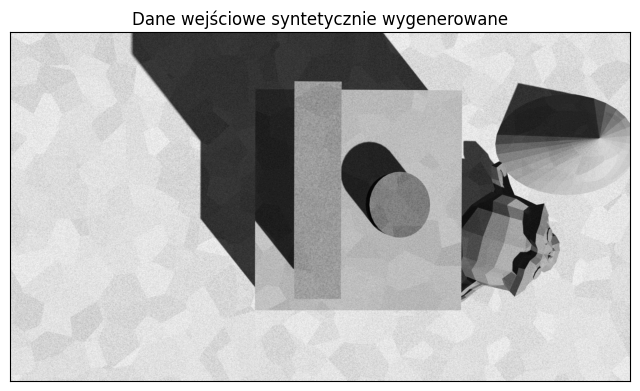

In [197]:
ret, first_frame = cap.read()
prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)
plt.imshow(prev_gray, cmap='gray')
plt.title('Dane wejściowe syntetycznie wygenerowane')
no_labels()
plt.show()

In [177]:

mask = np.zeros_like(first_frame)
mask[..., 1] = 255

In [178]:

def dense_flow(frames: int):
    cap = cv.VideoCapture("data/0001-0030.avi")
    ret, first_frame = cap.read()
    prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)
    prev_gray = cv.addWeighted(prev_gray, 2, prev_gray, 0, 0 )
    flow = None
    for _ in range(frames):
        ret, frame = cap.read()
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        gray = cv.addWeighted(gray, 2, gray, 0, 0 )
        flow = cv.calcOpticalFlowFarneback(
            prev=prev_gray,
            next=gray, 
            flow=flow,
            pyr_scale=0.5,
            levels=5,
            winsize=15,
            iterations=3,
            poly_n=5,
            poly_sigma=1.2,
            flags=0
        )
        prev_gray = gray

    magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])
    mask[..., 0] = angle * 180 / np.pi / 2
    mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
    rgb = cv.cvtColor(mask, cv.COLOR_HSV2BGR)
    # return rgb
    return magnitude

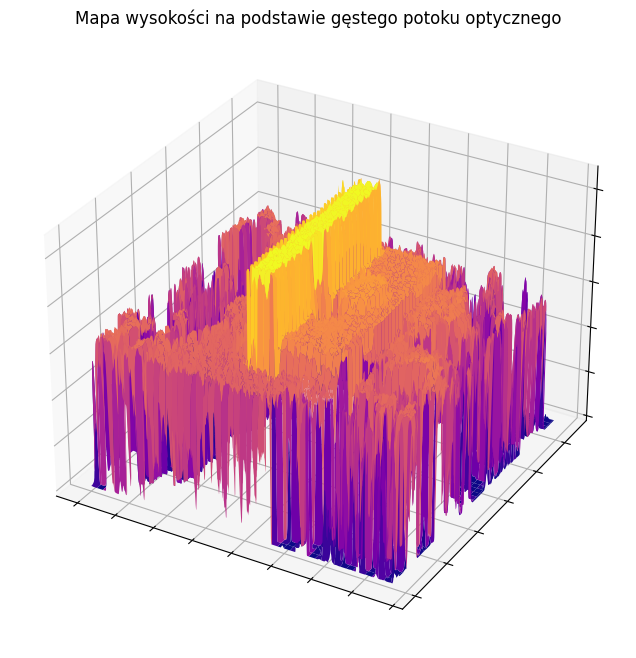

In [198]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
flow = dense_flow(3)
ys, xs = flow.shape
Y, X = np.mgrid[0:ys, 0:xs]
ax.plot_surface(X, Y, flow, cmap='plasma')
plt.title('Mapa wysokości na podstawie gęstego potoku optycznego')
no_labels()

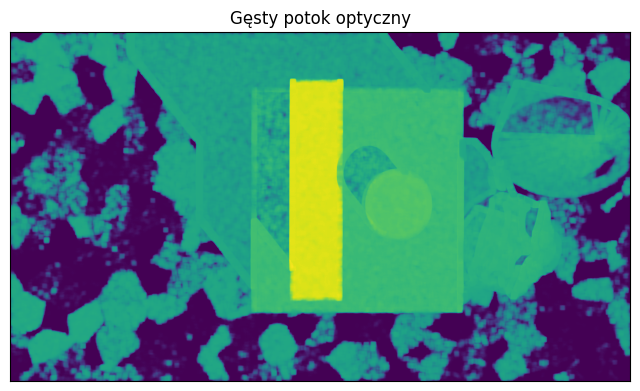

In [199]:
plt.imshow(flow)
plt.title('Gęsty potok optyczny')
no_labels()

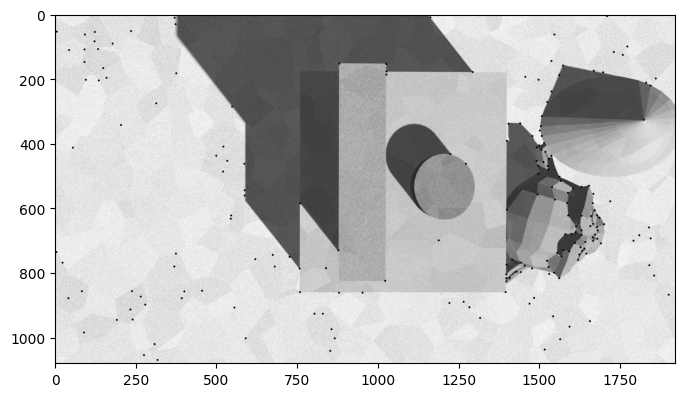

(<matplotlib.image.AxesImage at 0x2bdaefbcd10>, None)

In [200]:
ret, img = cap.read()
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
corners = cv.goodFeaturesToTrack(gray,200,0.01,10)
corners = np.intp(corners)
for i in corners:
    x,y = i.ravel()
    cv.circle(gray,(x,y),3,(255,0,0),-1)

ret, next_img = cap.read()
next_gray = cv.cvtColor(next_img,cv.COLOR_BGR2GRAY)
next_corners = cv.goodFeaturesToTrack(next_gray,200,0.01,10)
next_corners = np.intp(next_corners)
for i in corners:
    x,y = i.ravel()
    cv.circle(gray,(x,y),3,(0,255,0),-1)
plt.imshow(gray, cmap='gray'),plt.show()

In [201]:
cost = np.zeros((len(corners), len(next_corners)))
cost.size

40000

In [202]:
for c, corner in enumerate(corners):
    for n, next_corner in enumerate(next_corners):
        cost[c][n] = np.linalg.norm(corner - next_corner)

In [203]:
from scipy.optimize import linear_sum_assignment

In [204]:
row_ind, col_ind = linear_sum_assignment(cost)

In [205]:
cost[row_ind, col_ind].sum()

7452.174856048096

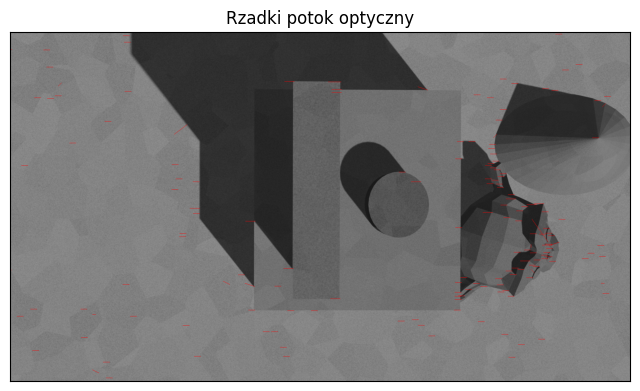

In [206]:
MULTIPLY_LENGTH = 10
vis = cv.cvtColor(next_gray, cv.COLOR_GRAY2RGB)
for r, c in zip(row_ind, col_ind):
    if cost[r, c] < 10:
        x, y = corners[r][0]
        next_x, next_y = next_corners[c][0]
        x += (next_x - x) * MULTIPLY_LENGTH
        y += (next_y - y) * MULTIPLY_LENGTH
        cv.line(vis, *corners[r], (x, y), (255,0,0), 1)
plt.imshow(vis, cmap='gray')
plt.title('Rzadki potok optyczny')
no_labels()

In [207]:
len(row_ind), len(col_ind)

(200, 200)

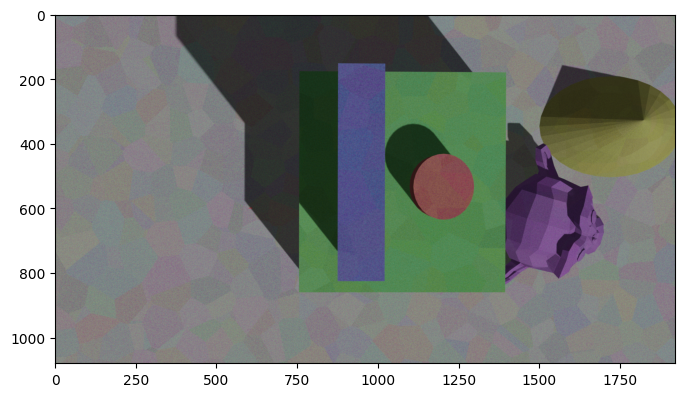

In [208]:
cv.line(next_img, (600,600), (610,600), (255,0,0), 1)
plt.imshow(next_img)

In [209]:
cap = cv.VideoCapture("data/0001-0030.avi")
ret, first_frame = cap.read()
prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)
mask = np.zeros_like(first_frame)
mask[..., 1] = 255

ret, frame = cap.read()
gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

flow = cv.calcOpticalFlowFarneback(prev_gray, gray, 
                                    None,
                                    0.5, 3, 15, 3, 5, 1.2, 0)